# Capacity Expansion Tutorial

In this tutorial, we will use `osier` to optimize the capacity for a test energy system using 
`osier`'s `CapacityExpansion` model.

In [1]:
# basic imports
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hour, day, MW

# osier imports
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

As before, `osier` needs two fundamental things in order to run the model

1. A technology set
2. A net demand profile

Let's create both of these, first. This time, we'll add some dummy "wind" profile and a wind technology to give `osier` something to optimize.
We'll also borrow some code from the dispatch tutorial.

## Creating the demand profile

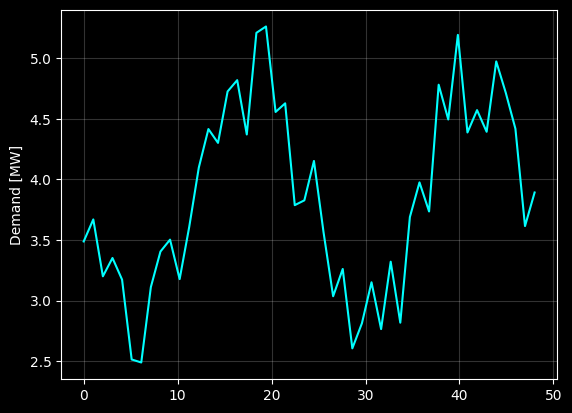

In [2]:
n_hours = 24  # hours per day
n_days = 2  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 185  # [MW], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

## Creating the "wind" profile

Wind speeds follow a Weibull distribution 

$f(v) = \left(\frac{k}{\lambda}\right)\left(\frac{v}{\lambda}\right)^{k-1}e^{-\left(\frac{v}{\lambda}\right)^k}$

Where $v$ is our random variable (velocity).

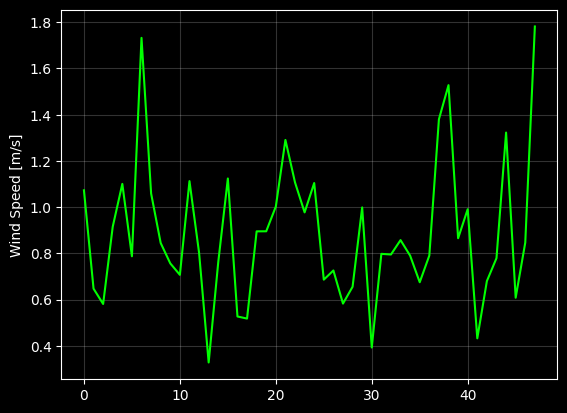

In [3]:
np.random.seed(123)
shape_factor = 2.5
wind_speed = np.random.weibull(a=shape_factor,size=N)

with plt.style.context('dark_background'):
    plt.plot(wind_speed, color='lime')
    plt.grid(alpha=0.2)
    plt.ylabel('Wind Speed [m/s]')
    plt.show()
    

`osier.CapacityExpansion` will normalize the wind and solar profiles and rescale the maximum values to the rated capacity of the installed technology (for each "individual" portfolio tested). Just for fun, let's plot the "net demand" if this wind speed were the true value.

Also note that the weibull distribution is related to wind *speed*, not energy production. For simplicity, we will assume they're equal.

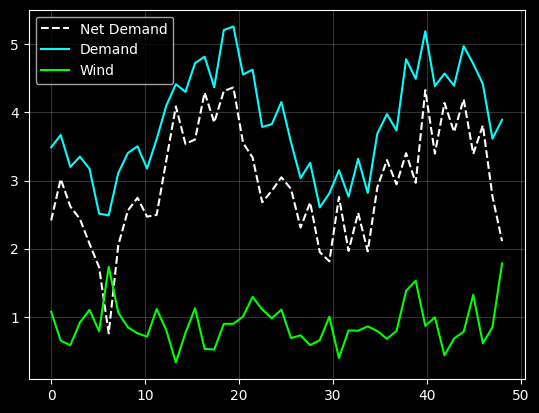

In [4]:
with plt.style.context('dark_background'):
    plt.plot(hours, demand-wind_speed, color='white', linestyle='--', label='Net Demand')
    plt.plot(hours, demand, color='cyan', label='Demand')
    plt.plot(hours, wind_speed, color='lime', label='Wind')
    plt.grid(alpha=0.2)
    plt.legend()
    plt.show()

## Creating the Technology Mix

Let's try to meet demand with a properly sized wind turbine and storage combination.

In [5]:
technologies = [lib.battery, lib.wind]
technologies

[Battery: 815.3412599999999 MW, WindTurbine: 0.0 MW]

## Setting up the Capacity Expansion Problem

`osier.CapacityExpansion` inherits from a `pymoo.Problem` object. This class does not run the optimization itself, so we'll have to add the `pymoo` pieces later. Before we can instantiate the problem, though, we need to define the **objectives** to optimize over!

### Defining objectives

`osier` comes with a set of predefined objectives, such as cost and carbon emissions. Let's start with cost.

In [6]:
from osier import total_cost

In [7]:
problem = CapacityExpansion(technology_list = [lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            objectives = [total_cost],
                            verbosity='verbose')  # the objectives must be passed as a LIST of functions!

### Setting up a Pymoo algorithm

Pymoo might seem intimidating, but it too requires only a few fundamental pieces

1. An algorithm object (imported from Pymoo)
2. A problem to optimize (we created this in the previous cell!)
3. A stopping criterion.

The rest is sugar.

In [8]:
algorithm = NSGA2(pop_size=20)

import time
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination=('n_gen', 10),
               seed=1,
               save_history=True,
               verbose='verbose')
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

CapacityExpansion Problem
Technologies:

Technology Name | Capacity 

NaturalGas_Conv: 2.1946144876594618 MW
Battery: 3.7907701543269803 MW

Electricity Demand:

[3.4875975  3.66942782 3.19975268 3.3510181  3.17234031 2.5131901
 2.48826265 3.11086521 3.40424932 3.50249027 3.17647237 3.60811879
 4.0981677  4.41558611 4.30135989 4.72606563 4.81930702 4.37090473
 5.21011483 5.26258678 4.55680389 4.62804161 3.7872909  3.82700266
 4.15236646 3.56351161 3.03511766 3.26045497 2.60478782 2.81182989
 3.15051906 2.76370612 3.32037742 2.8169647  3.68945037 3.97526723
 3.73506476 4.781829   4.4944826  5.19307176 4.38737607 4.57185419
 4.3930609  4.97410534 4.71360814 4.41799012 3.61435886 3.8918281 ] MW
ERROR: evaluating object as numeric value: x[NaturalGas_Conv,0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[NaturalGas_Conv,0]
CapacityExpansion Problem
Technologies:

Technology Name | Capacity 

NaturalGas_Conv: 0.0006019074

In [9]:
display(res.F, res.X)

array([0.26153658])

array([0.77856667, 0.24877284])

## Checking the results

In [15]:
from osier import DispatchModel

lib.battery.capacity =  0.48593986783563375*MW
lib.natural_gas.capacity = 0.7723156104587652*MW

technologies = [lib.natural_gas, lib.battery]
display(technologies)

model = DispatchModel(technology_list=technologies,
                      net_demand=demand)
model.solve(solver='glpk')


[NaturalGas_Conv: 0.7723156104587652 MW, Battery: 0.48593986783563375 MW]

ERROR: evaluating object as numeric value: x[NaturalGas_Conv,0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object x[NaturalGas_Conv,0]


In [16]:
lib.battery.capacity =  0.24877284*demand.max()*MW
lib.natural_gas.capacity = 0.77856667*demand.max()*MW

technologies = [lib.natural_gas, lib.battery]
display(technologies)

model = DispatchModel(technology_list=technologies,
                      net_demand=demand)
model.solve(solver='glpk')

[NaturalGas_Conv: 4.097274662543094 MW, Battery: 1.309188658256957 MW]

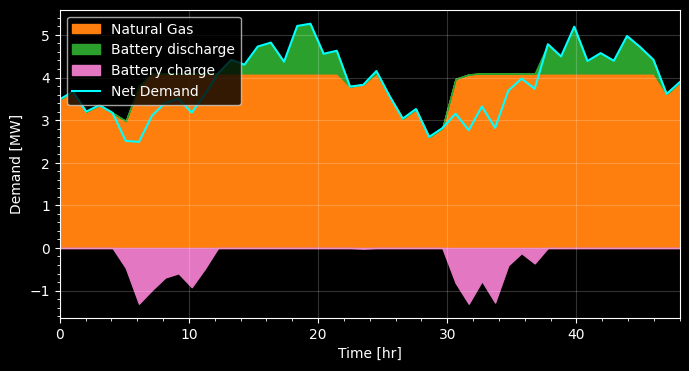

In [17]:
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.grid(alpha=0.2)
    ax.minorticks_on()
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['NaturalGas_Conv'].values, 
                    color='tab:orange', 
                    label='Natural Gas')
    ax.fill_between(hours, 
                    y1=model.results['NaturalGas_Conv'].values, 
                    y2=model.results['Battery'].values+model.results['NaturalGas_Conv'].values, 
                    color='tab:green', 
                    label='Battery discharge')
    ax.fill_between(hours, 
                    y1=0, 
                    y2=model.results['Battery_charge'].values, 
                    color='tab:pink', 
                    label='Battery charge')
    ax.plot(hours, model.net_demand, color='cyan', label='Net Demand')
    ax.set_xlim(0,48)
    # ax.set_ylim(0,5.5)
    ax.legend(loc='upper left')
    ax.set_ylabel("Demand [MW]")
    ax.set_xlabel("Time [hr]")
    plt.show()